# Figure 2
We show that wide shallow nets with engineered activation functions can realize the performance of desired deep ReLU kernels on CIFAR-10.

# Imports

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents
!sudo apt-get install texlive-latex-recommended
!sudo apt install texlive-latex-extra
!sudo apt install dvipng
!sudo apt install cm-super dvipng
!pip install pmlb
!pip install cifar10_web

import cifar10_web

import cvxopt

import jax.nn
import jax.numpy as np
from jax import random
from jax.api import jit, grad, vmap
from jax.config import config
from jax.experimental import optimizers
from jax.ops import index_update

import neural_tangents as nt
from neural_tangents import stax

import numpy as base_np

import pandas as pd

from scipy.special import factorial, factorial2

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

np.set_printoptions(precision=4, linewidth=200)

key = random.PRNGKey(17)

# Datasetup

CIFAR-10 data as in the other notebooks, normalized as described in the paper.

In [ ]:
def get_cifar10(n_train=None):
  train_X, train_y, test_X, test_y = cifar10_web.cifar10(path=None)

  # NORMALIZE GLOBALLY
  train_mean = train_X.mean()
  train_std = train_X.std()
  train_X = (train_X - train_mean)/train_std
  test_X = (test_X - train_mean)/train_std
  # NORMALIZE LOCALLY
  train_X = train_X/((train_X**2).mean(axis=1)**.5)[:,None]
  test_X = test_X/((test_X**2).mean(axis=1)**.5)[:,None]

  if n_train is not None:
    train_X = train_X[:n_train]
    train_y = train_y[:n_train]

  return train_X, train_y, test_X, test_y

# Net setup

In [ ]:
def get_net_functions(d_in, width, d_out, n_hidden_layers=1, phi=None, deg=40, centered=False, W_std=None, b_std=None):
    global key

    init_fn, apply_fn_uncentered, kernel_fn = None, None, None

    # if there's a phi, make a net with activation function phi
    if phi is not None and phi != 'relu':
      if phi == 'erf':
        W_std = W_std if W_std is not None else 1.5
        b_std = b_std if b_std is not None else 0.3
        layers = [stax.Dense(width, W_std=W_std, b_std=b_std), stax.Erf()]*n_hidden_layers
        layers += [stax.Dense(d_out, W_std=1, b_std=0)]
        init_fn, apply_fn_uncentered, kernel_fn = stax.serial(*layers)
      else:
        W_std = W_std if W_std is not None else 1
        b_std = b_std if b_std is not None else 0
        layers = [stax.Dense(width, W_std=W_std, b_std=b_std), stax.ElementwiseNumerical(fn=phi, deg=deg)]*n_hidden_layers
        layers += [stax.Dense(d_out, W_std=1, b_std=0)]
        init_fn, apply_fn_uncentered, kernel_fn = stax.serial(*layers)

    # otherwise, make a relu net
    else:
      W_std = W_std if W_std is not None else 1.5
      b_std = b_std if b_std is not None else 0.1
      layers = [stax.Dense(width, W_std=W_std, b_std=b_std), stax.Relu()]*n_hidden_layers
      layers += [stax.Dense(d_out, W_std=1, b_std=0)]
      init_fn, apply_fn_uncentered, kernel_fn = stax.serial(*layers)

    key, net_key = random.split(key)
    _, initial_params = init_fn(net_key, (-1, d_in))
    apply_fn = jit(apply_fn_uncentered) if not centered else jit(lambda params, x: apply_fn_uncentered(params, x) - apply_fn_uncentered(initial_params, x))

    return init_fn, apply_fn, kernel_fn, initial_params

In [ ]:
def get_batched_kernel_fn(kernel_fn, k_batch_size=100):
  def batched_kernel_fn(x1, x2, get=None):
    x2 = x1 if x2 is None else x2
    get = get[0] if get in [('nngp',),('ntk',)] else get
    kernel_fn_jit = jit(lambda x1,x2: kernel_fn(x1, x2, get))
    # subkernels = [kernel_fn(x1, x2[k_batch_size*i:min(k_batch_size*(i+1), x2.shape[0])], get=get) for i in range(int(np.ceil(x2.shape[0]/k_batch_size)))]
    subkernels = [kernel_fn_jit(x1, x2[k_batch_size*i:min(k_batch_size*(i+1), x2.shape[0])]) for i in range(int(np.ceil(x2.shape[0]/k_batch_size)))]
    output = np.concatenate(subkernels, axis=1)
    return output
  return batched_kernel_fn

In [ ]:
mse = lambda y_hat, y_true: 0.5 * ((y_hat - y_true) ** 2).sum(axis=1).mean()
percent_correct = jit(lambda y_hat, y_true: 100*(np.argmax(y_hat, axis=1) == np.argmax(y_true, axis=1)).mean())

# Phi generation functions

In [ ]:
def psd_poly_fit(xs, fs, deg=5):
  Q = base_np.zeros((deg+1, deg+1))
  p = base_np.zeros((deg+1,))
  G = -1*base_np.eye(deg+1)
  h = 0*p

  for i in range(deg + 1):
    for j in range(deg + 1):
      Q[i][j] = 2*(xs**(i+j)).sum()
  for i in range(deg + 1):
    p[i] = -2*((xs**i)*fs).sum()
  
  Q = (10**3)*cvxopt.matrix(Q)
  p = (10**3)*cvxopt.matrix(p)
  G = cvxopt.matrix(G)
  h = cvxopt.matrix(h)
  
  cvxopt.solvers.options['show_progress'] = False
  sol = cvxopt.solvers.qp(Q, p, G, h)

  return base_np.array(sol['x']).flatten()

In [ ]:
def poly_coeffs_to_lambda_fn_string(c_alpha):
  output = "lambda z: "
  for i in range(len(c_alpha)):
    coeff = c_alpha[i]/factorial(i)
    if coeff != 0:
      output += str(coeff) + "*z**" + str(i) + " + "
  return(output[:-3])

In [ ]:
def phi_from_kernel_fn(kernel_fn, k_type, deg=10, n_sample_pts=1000, weight_on_endpts=0):
  d_in = 2
  n_sample_pts = n_sample_pts
  xis = np.linspace(1,-1,n_sample_pts)

  # if weighting the endpoints higher, add more -1s and +1s to xis
  if weight_on_endpts > 0:
    n_interior_pts = int(n_sample_pts*(1 - 2*weight_on_endpts))
    n_endpts = int(n_sample_pts*weight_on_endpts)
    xis = np.linspace(1, -1, n_interior_pts + 2)
    xis = np.concatenate([np.array([1]*(n_endpts - 1)), xis, np.array([-1]*(n_endpts - 1))])

  sines = (1 - xis**2)**.5
  u0 = index_update(np.zeros(d_in), 0, 1)
  u1 = index_update(np.zeros(d_in), 1, 1)
  xs = np.outer(xis, u0) + np.outer(sines, u1)
  xs = (d_in**.5)*xs

  Ks = kernel_fn(xs[0:1], xs, k_type)[0]

  desired_coeffs = psd_poly_fit(xis, Ks, deg=deg)
  desired_coeffs *= (np.array(np.abs(desired_coeffs) > 10**-3))
  print('approximating K as a polynomial with coeffs', desired_coeffs)

  # construct matrix for going from K (i.e. a_gamma) to phi (i.e. c_alpha)
  Minv = [[(-1)**((col - row)/2)/factorial2(col - row)
          if (col >= row)*((col + row)%2 == 0)
          else 0
          for col in range(deg + 1)]
          for row in range(deg + 1)]
  Minv = np.array(Minv)

  a_gamma = [desired_coeffs[gamma]*factorial(gamma) if gamma < len(desired_coeffs) else 0 for gamma in range(len(Minv))]
  b_gamma = np.array(a_gamma)**.5
  c_alpha = np.matmul(Minv, np.array(b_gamma))

  phi_def_string = poly_coeffs_to_lambda_fn_string(c_alpha)
  phi = eval(phi_def_string)

  string_to_print = '\\phi(z) = '
  for alpha in range(len(c_alpha)):
    coeff = c_alpha[alpha]/factorial(alpha)
    if abs(coeff) > 0:
      if string_to_print[-2] != '=':
        if coeff < 0:
          string_to_print += ' - '
        else:
          string_to_print += ' + '
      else:
        if coeff < 0:
          string_to_print += '-'
      coeff = abs(coeff)
      string_to_print += f'{coeff:.4}'
      if alpha > 0:
        string_to_print += ' z'
        if alpha > 1:
          string_to_print += f'^{{{alpha}}}'
  print('\n' + string_to_print + '\n')

  return phi

# Net depth comparison plot function

Emulate the performance of depth 15, NNGP ReLU kernel via wide single-hidden-layer networks of varying degree polynomial. Compare this to the performance of NNGP and NTK kernels of different depths and activation functions.

In [ ]:
def get_deep_net_results(dataset, max_depth=10, max_phi_deg=10):
  train_X, train_y, test_X, test_y = dataset
  d_in = train_X.shape[1]
  d_out = train_y.shape[1]
  
  depths = list(range(1, max_depth+1, 1))

  # SHALLOW NET

  testlosses_shallow = []
  testaccs_shallow = []

  for phi_deg in range(2, max_phi_deg+1, 1):
    # emulate 15 relu (nngp)
    _, _, kernel_target, _ = get_net_functions(d_in, 1000, d_out, n_hidden_layers=15, phi='relu', b_std=.1)
    phi = phi_from_kernel_fn(kernel_target, 'nngp', deg=phi_deg, weight_on_endpts=.1)

    init_fn, apply_fn, kernel_fn, initial_params = get_net_functions(d_in, 1000, d_out, n_hidden_layers=1, phi=phi)
    batched_kernel_fn = get_batched_kernel_fn(kernel_fn, k_batch_size=1000)
    predict_fn = nt.predict.gradient_descent_mse_ensemble(batched_kernel_fn, train_X[:], train_y[:])
    inf_width_test_preds = predict_fn(x_test=test_X, get='nngp', compute_cov=False)
    testloss_shallow = mse(inf_width_test_preds, test_y)
    testacc_shallow = percent_correct(inf_width_test_preds, test_y)
    testlosses_shallow += [testloss_shallow]
    testaccs_shallow += [testacc_shallow]
  
  for phi_deg in range(2, max_phi_deg+1, 1):
    print("shallow ["+str(phi_deg)+"] (nngp)      	  loss: {:9.5f}".format(testlosses_shallow[phi_deg-2]), "\t\t\tacc: {:7.2f}".format(testaccs_shallow[phi_deg-2]))
  print()

  testlosses_erf = {'nngp':[], 'ntk':[]}
  testaccs_erf = {'nngp':[], 'ntk':[]}
  # LOOP THROUGH ERF NETS OF DIFFERENT DEPTHS
  for n_hidden_layers in depths:
    init_fn, apply_fn, kernel_fn, initial_params = get_net_functions(d_in, 1000, d_out, n_hidden_layers=n_hidden_layers, phi='erf')
    batched_kernel_fn = get_batched_kernel_fn(kernel_fn, k_batch_size=1000)

    predict_fn = nt.predict.gradient_descent_mse_ensemble(batched_kernel_fn, train_X[:], train_y[:])

    for k_type in ['nngp', 'ntk']:
      inf_width_test_preds = predict_fn(x_test=test_X, get=k_type, compute_cov=False)
      testlosses_erf[k_type] += [mse(inf_width_test_preds, test_y)]
      testaccs_erf[k_type] += [percent_correct(inf_width_test_preds, test_y)]

    print("erf depth ", n_hidden_layers,
          " \tloss (nngp):", "{:9.5f}".format(testlosses_erf['nngp'][-1]),
          " \tacc (nngp):", "{:7.2f}".format(testaccs_erf['nngp'][-1]), 
          " \t\t loss (ntk):", "{:9.5f}".format(testlosses_erf['ntk'][-1]),
          " \tacc (ntk):", "{:7.2f}".format(testaccs_erf['ntk'][-1]), )

  testlosses_relu = {'nngp':[], 'ntk':[]}
  testaccs_relu = {'nngp':[], 'ntk':[]}
  print()
  # LOOP THROUGH ERF NETS OF DIFFERENT DEPTHS
  for n_hidden_layers in depths:
    init_fn, apply_fn, kernel_fn, initial_params = get_net_functions(d_in, 1000, d_out, n_hidden_layers=n_hidden_layers, phi='relu')
    batched_kernel_fn = get_batched_kernel_fn(kernel_fn, k_batch_size=1000)

    predict_fn = nt.predict.gradient_descent_mse_ensemble(batched_kernel_fn, train_X[:], train_y[:])

    for k_type in ['nngp', 'ntk']:
      inf_width_test_preds = predict_fn(x_test=test_X, get=k_type, compute_cov=False)
      inf_width_loss = mse(inf_width_test_preds, test_y)
      testlosses_relu[k_type] += [mse(inf_width_test_preds, test_y)]
      testaccs_relu[k_type] += [percent_correct(inf_width_test_preds, test_y)]

    print("relu depth ", n_hidden_layers,
          " \tloss (nngp):", "{:9.5f}".format(testlosses_relu['nngp'][-1]),
          " \tacc (nngp):", "{:7.2f}".format(testaccs_relu['nngp'][-1]), 
          " \t\t loss (ntk):", "{:9.5f}".format(testlosses_relu['ntk'][-1]),
          " \tacc (ntk):", "{:7.2f}".format(testaccs_relu['ntk'][-1]), )

  return testlosses_relu, testaccs_relu, testlosses_erf, testaccs_erf, testlosses_shallow, testaccs_shallow

In [ ]:
# LOAD DATA
dataset_cifar10 = get_cifar10(n_train=10000)
d_in = dataset_cifar10[0].shape[1]
d_out = 10
# train_X, train_y, test_X, test_y = get_cifar10(n_train=10000)

Downloaded cifar-10-binary.tar.gz to /root/data/cifar10


In [ ]:
max_depth = 15
max_phi_deg = 20
testlosses_relu, testaccs_relu, testlosses_erf, testaccs_erf, testlosses_shallow, testaccs_shallow = get_deep_net_results(dataset_cifar10, max_depth=max_depth, max_phi_deg=max_phi_deg)

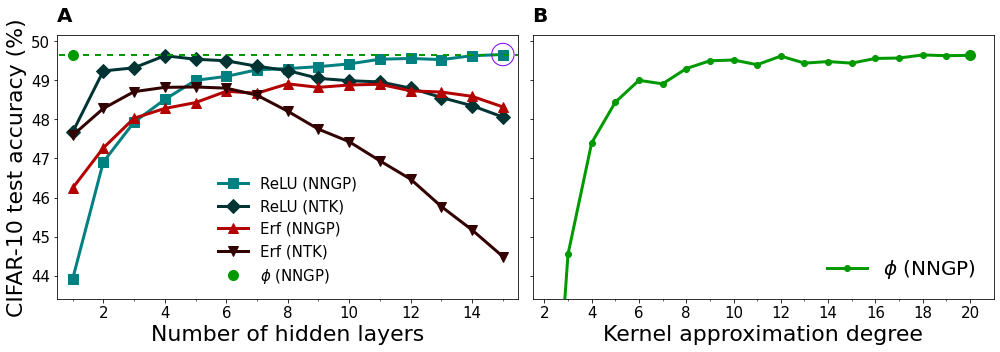

In [ ]:
# fig, ax = plt.subplots(figsize=(10,6))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
axs[0].get_shared_y_axes().join(axs[0], axs[1])
# fig = plt.figure(figsize=(20, 6))
# axs = [None, None]
# axs[0] = plt.subplot(1, 2, 1)
# axs[1] = plt.subplot(1, 2, 2, sharey=axs[0])

ax = axs[0]
kwargs = {'lw':3, 'markersize':10}
depths = list(range(1, max_depth+1, 1))
ax.plot(depths, testaccs_relu['nngp'], 's-', color=(0,.5,.5), label='ReLU (NNGP)', **kwargs)
ax.plot(depths, testaccs_relu['ntk'], 'D-', color=(0,.2,.2), label='ReLU (NTK)', **kwargs)
ax.plot(depths, testaccs_erf['nngp'], '^-', color=(.7,0,0), label='Erf (NNGP)', **kwargs)
ax.plot(depths, testaccs_erf['ntk'], 'v-', color=(.2,0,0), label='Erf (NTK)', **kwargs)
ax.plot([1], [testaccs_shallow[max_phi_deg-2]], 'o', color=(0,.6,0), label='$\\phi$ (NNGP)', **kwargs)
ax.plot([-100,100], [testaccs_shallow[max_phi_deg-2]]*2, lw=2, linestyle=(0,(3,3)), color=(0,.6,0))
ax.set_xlabel('Number of hidden layers', fontsize=22)
ax.set_ylabel('CIFAR-10 test accuracy (%)', fontsize=22)
ax.set_xticks(list([i for i in range(2,20,2)]), minor=False)
ax.set_xticks(list([i for i in range(1,20,2)]), minor=True)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(prop=dict(size=15), frameon=False)
ax.set_xlim(min(depths) - .5, max(depths) + .5)
for s in range(500, 550, 50):
  ax.scatter(max_depth, max(testaccs_relu['nngp']), edgecolor=(.5,0,1), facecolor='none', s=s, zorder=10)
# ax.add_patch(plt.Circle((max_depth, max(testaccs_relu['nngp'])), 1, color=(1,0,1), clip_on=False))

ax = axs[1]
degs = list(range(2, max_phi_deg+1, 1))
ax.plot(degs, testaccs_shallow, 'o-', color=(0,.6,0), lw=3, markersize=6, label='$\\phi$ (NNGP)')
ax.plot(degs[-1], testaccs_shallow[-1], 'o-', color=(0,.6,0), markersize=10)
ax.set_xlabel('Kernel approximation degree', fontsize=22)
ax.set_xticks(list([i for i in range(2,max_phi_deg+1,2)]), minor=False)
ax.set_xticks(list([i for i in range(1,max_phi_deg+1,2)]), minor=True)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlim((1.5, max_phi_deg+1))
ax.set_ylim((min(testaccs_relu['nngp']) - .5, max(testaccs_relu['nngp']) + .5))
ax.legend(prop=dict(size=20), frameon=False, loc='lower right')

axs[0].text(0, 1.05, 'A', transform=axs[0].transAxes, size=20, weight='bold')
axs[1].text(0, 1.05, 'B', transform=axs[1].transAxes, size=20, weight='bold')

fig.tight_layout()

plt.savefig('fig2.png', transparent=True, dpi=300, bbox_inches='tight')